In [1]:
import glob # A common system tool for finding and parsing files 
data_dir = './rti_examples' # The name of the folder with the files  
rti_filenames = glob.glob(f'{data_dir}/*.rti') # Finding all files in the folder that end in .rti
num_files = len(rti_filenames)
print(f'Found {num_files:.0f} RTI files.')

Found 5 RTI files.


In [2]:
import pickle # For loading files

file_name = 'RTI_zephyrtx3_zephyrrx2_1678334631_15s.rti'#'RTI_zephyrtx3_zephyrrx2_1678336626_15s.rti'
with open(f'{data_dir}/{file_name}', "rb") as f:
        rti_xarray = pickle.load(f)
print(rti_xarray)
print(type(rti_xarray))

<xarray.DataArray (tx_rx_channel_pair: 12, doppler_hz: 1, gate: 1000, time: 3000)> Size: 288MB
array([[[[-1.18097949e+03-1.51997156e+03j,
          -1.66797168e+03-3.77691772e+03j,
           1.91694800e+03+4.66944855e+02j, ...,
          -1.59615202e+01-5.89008606e+02j,
           1.96694666e+03-2.91798022e+03j,
          -8.25990601e+02-3.77004333e+02j],
         [ 1.41495654e+03-4.48795020e+03j,
           5.39988184e+03-5.12497754e+03j,
          -4.69671288e+01-6.07889062e+03j, ...,
           1.37177705e+04-2.13497412e+03j,
           1.35068066e+04-2.93999976e+03j,
           1.35917588e+04-7.42993958e+02j],
         [ 1.70233574e+01-5.11998926e+03j,
           1.24606946e+03-2.87303760e+03j,
           3.30494385e+03-4.87502002e+03j, ...,
           1.28060156e+04-4.45028259e+02j,
           1.25670156e+04-2.19001245e+03j,
           1.43259873e+04+4.00980896e+02j],
         ...,
         [-3.62891968e+03+1.63798389e+03j,
...
           5.38796680e+03-7.48902148e+03j],
        

In [3]:
import numpy as np 

ht_max = 110e3 # [m] 
gate_wd = 1.5e3 # [m] 
el_min_deg = 20 # [deg] 
R_max = ht_max / np.sin(np.deg2rad(el_min_deg))
max_gate = int(R_max // gate_wd)
print(f'Max gate for a meteor at {ht_max * 1e-3:.0f} km \
and {el_min_deg:.0f} deg. elevation is gate {max_gate:.0f}.')

Max gate for a meteor at 110 km and 20 deg. elevation is gate 214.


In [4]:
ht_max_plane = 12e3 # [m]. This is about 40,000 ft 
R_max_plane = ht_max_plane / np.sin(np.deg2rad(el_min_deg))
max_gate_plane = int(R_max_plane // gate_wd)
print(f'Max gate for a plane at {ht_max_plane * 1e-3:.0f} km \
and {el_min_deg:.0f} deg. elevation is gate {max_gate_plane:.0f}.')

Max gate for a plane at 12 km and 20 deg. elevation is gate 23.


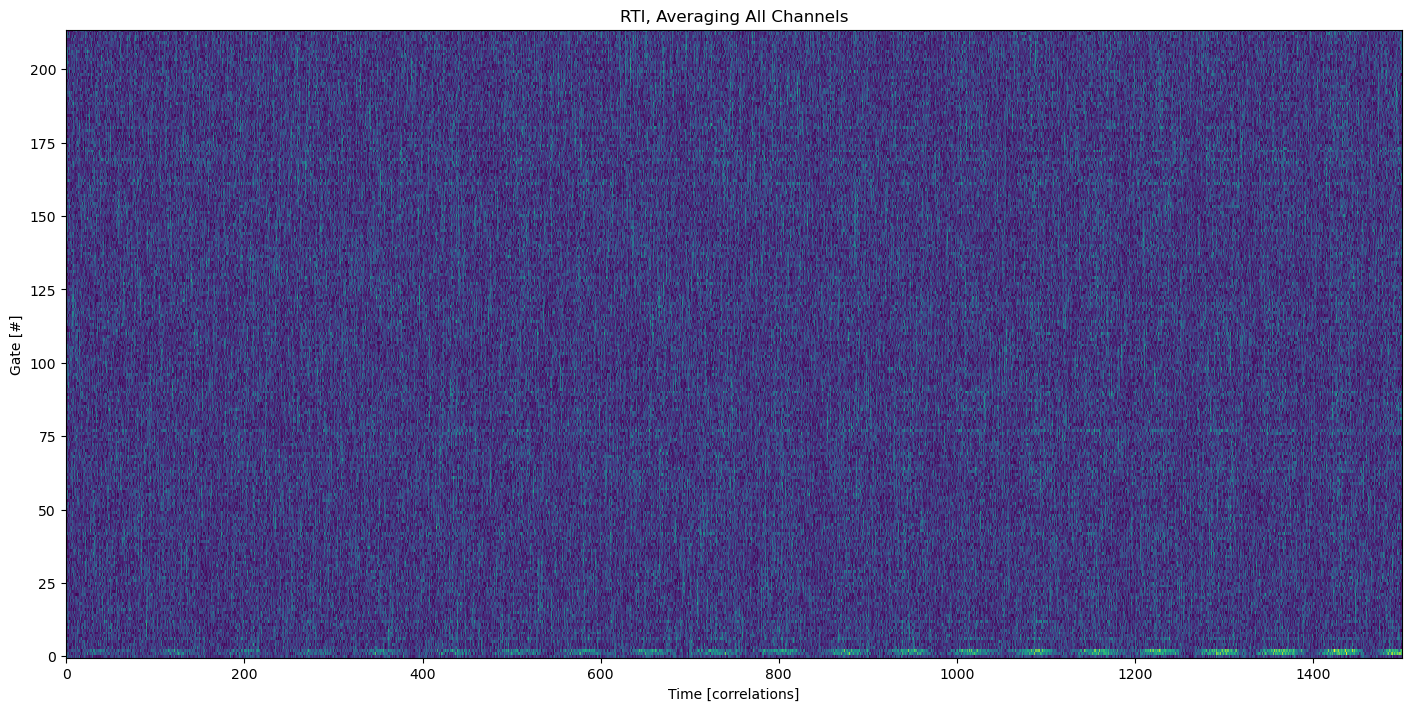

In [5]:
import matplotlib.pyplot as plt # Plotting 
from matplotlib.ticker import MaxNLocator

# RTI diagram
rti_array = rti_xarray.values[:, 0, :max_gate, :1500]
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
rti_for_plot = np.abs(rti_array.mean(0))  # Collapse Doppler Dimension, mean across channels

ax.imshow(rti_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

(321000, 1)


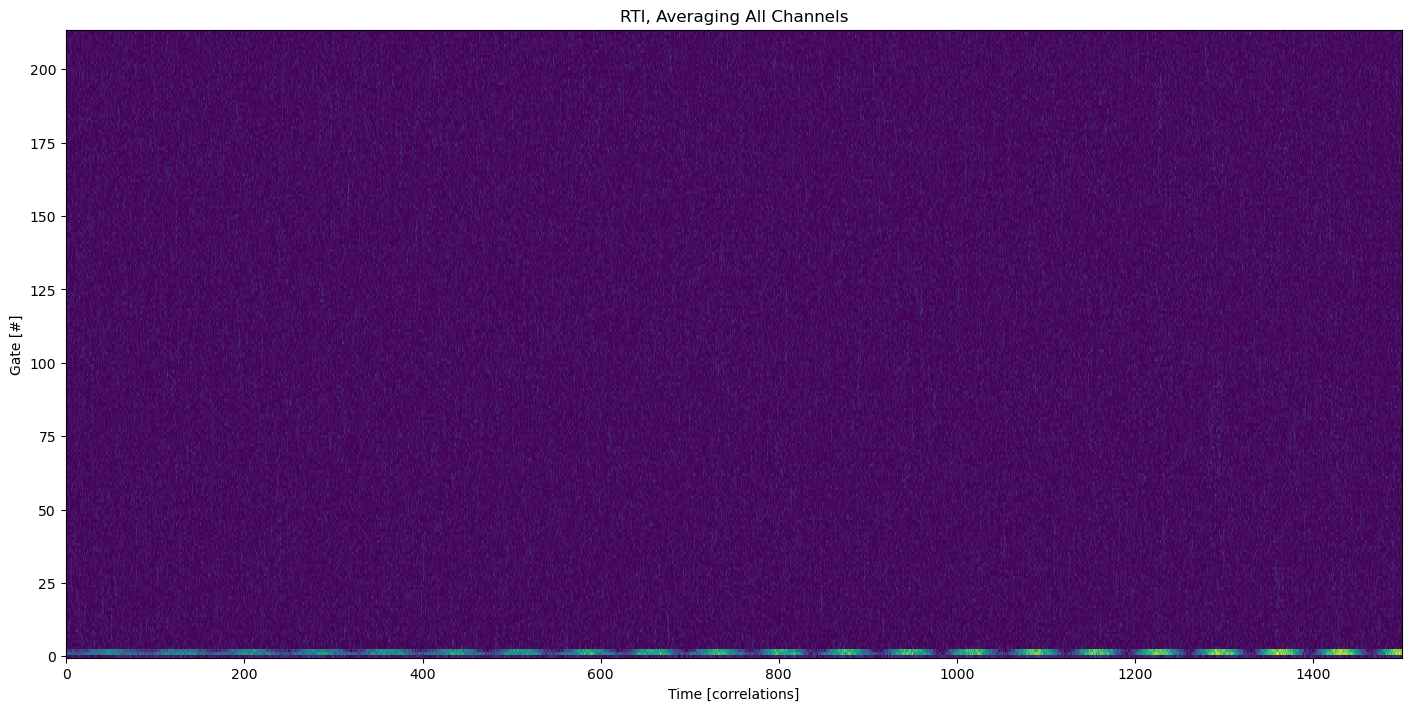

In [6]:
from sklearn.decomposition import PCA

# Performing PCA 
n_ch, n_gates, n_times = rti_array.shape
X = np.moveaxis(rti_array, 0, -1).reshape(-1, n_ch)
X = abs(X)
pca = PCA(n_components=1)
pca.fit(X)
rti_PCA = pca.fit_transform(X)
print(rti_PCA.shape)
rti_PCA = np.reshape(rti_PCA, (n_gates, n_times, 1)).squeeze()

# Plotting 
fig, ax = plt.subplots(1, 1, figsize=(14, 7), layout='constrained')
pca_for_plot = np.abs(rti_PCA[:, :])
ax.imshow(pca_for_plot, origin='lower', aspect='auto', interpolation='none', extent=None)
ax.set_xlabel('Time [correlations]')
ax.set_ylabel('Gate [#]')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('RTI, Averaging All Channels')
plt.show()

In [7]:
def cfar(X_k, num_guard_cells, num_ref_cells, bias, cfar_method="average"):
    N = X_k.size
    cfar_values = np.zeros(X_k.shape)
    for center_index in range(
        num_guard_cells + num_ref_cells, N - (num_guard_cells + num_ref_cells)
    ):
        min_index = center_index - (num_guard_cells + num_ref_cells)
        min_guard = center_index - num_guard_cells
        max_index = center_index + (num_guard_cells + num_ref_cells) + 1
        max_guard = center_index + num_guard_cells + 1

        lower_nearby = X_k[min_index:min_guard]
        upper_nearby = X_k[max_guard:max_index]

        lower_mean = np.mean(lower_nearby)
        upper_mean = np.mean(upper_nearby)

        if cfar_method == "average":
            mean = np.mean(np.concatenate((lower_nearby, upper_nearby)))
        elif cfar_method == "greatest":
            mean = max(lower_mean, upper_mean)
        elif cfar_method == "smallest":
            mean = min(lower_mean, upper_mean)
        else:
            mean = 0

        output = mean * bias
        cfar_values[center_index] = output

    targets_only = np.copy(X_k)
    targets_only[np.where(X_k < cfar_values)] = np.ma.masked

    return cfar_values, targets_only

# Using the RTI data in Function

n_ch, n_gates, n_times = rti_array.shape
single_time=rti_array[4,:,150] #this should be the RTI array at a given time Of interest: times: 10,1011, Gates: 9

plt.plot(single_time) #Plot of what I think is the recieved stuff against the gate.
plt.title("")

threshold, targets_only=cfar(single_time,num_guard_cells=2, num_ref_cells=8, bias=2) #Run cfar algorithm on RTI Data

plt.plot(single_time,c='b') #Plots RTI data
plt.plot(threshold,label="Threshold",c='r') #Plots Threshold in Red
plt.plot(targets_only,c='g') #Plots target values in green
plt.show

single_gate=rti_array[4,9,:] #Pairings 4 and 9 look significantly different
plt.plot(single_gate)
plt.title("Plane, ch4 all times")

# Using RTI_PCA data in function
It might also be a good idea to figure out how to slice along gate values just for future reference, and understanding of this code

single_time_PCA=rti_PCA[:,150]
plt.plot(single_time_PCA)

threshold, targets_only=cfar(single_time_PCA,num_guard_cells=3, num_ref_cells=3, bias=3)
plt.plot(single_time_PCA,c='b')
plt.plot(threshold,label="Threshold",c='r')
plt.plot(targets_only,c='g')
plt.show

single_gate_PCA=rti_PCA[9,:]
plt.plot(single_gate_PCA)
plt.title("Plane, PCA all times") 

# Using RTI Pair avg in function

rti_mean=rti_array.mean(0)
rti_mean.shape
single_time_avg=rti_mean[:,150]
single_gate_avg=rti_mean[9,:]
plt.plot(single_time_avg)

threshold, targets_only=cfar(single_time_avg,num_guard_cells=5, num_ref_cells=10, bias=10)
plt.plot(single_time_avg,c='b')
plt.plot(threshold,label="Threshold",c='r')
plt.plot(targets_only,c='g')
plt.show

plt.plot(single_gate_avg)
plt.title("Plane, avg all times") 

# Using Zephyr Inputs in CFAR algorithm

In [8]:
from Plane_Detection import *

### Code from Zephyr Repo
Code from the Zephyr repository which preps the data for use in detection algorithms.

In [9]:
def parse_selection(selection): #Other function from zephyr which I couldn't get to work.
    """
    Parse selection for slices or ranges, with support for 'all' and specific indices or ranges.

    Parameters:
    - selection: Can be 'all', a string for channel names, or a list of indices.
    """
    # If selection is "all", return a slice that selects everything
    if isinstance(selection, str) and selection == "all":
        return slice(None)  # Select all elements
    
    # If selection is a string like "120:-1", handle as a slice
    elif isinstance(selection, str) and ":" in selection:
        try:
            return slice(*map(lambda x: int(x) if x.strip() else None, selection.split(":")))
        except ValueError as e:
            raise ValueError(f"Invalid slice string: '{selection}'. Error: {e}")
    
    # If selection is a list or array of values, return it as-is
    elif isinstance(selection, (list, np.ndarray)):
        return selection
    
    else:
        raise ValueError(f"Invalid selection format: '{selection}'.")

In [10]:
def reduce_xarray(xarray_in, dim_operations, value_agg_func=np.abs): #Function from zephyr that I couldn't get to work
    """
    Reduces the RTI data based on the provided dimension operations (aggregation, selection).
    
    Parameters:
    - dim_operations (dict): Specifies "agg_func" and "selection" for each dimension.
        dim_operations = {
            "tx_rx_channel_pair": {"agg_func": None, "selection": "all"},  # Select polarimetric channels
            "doppler_hz": {"agg_func": None, "selection": [0]},  # Slice specific range
            "gate": {"agg_func": None, "selection": "all"},  # No aggregation
            "time": {"agg_func": None, "selection": "all"}  # Median over specific time slice
            }
    - value_agg_func (callable): Function to transform the data (e.g., np.abs, np.angle).
    
    Returns:
    - reduced_data (numpy.ndarray): Reduced data (2D or 3D) ready for plotting.
    """
    xarray_out = xarray_in.copy()
    xarray_out.attrs =  xarray_in.attrs.copy()
    
    # Apply operations for each dimension
    for dim, operations in dim_operations.items():
        if dim not in xarray_out.dims:
            raise ValueError(f"Dimension '{dim}' not found in data.")

        # Apply selection
        selection = operations.get("selection", "all")
        if dim == "tx_rx_channel_pair" and selection == "polarimetric":
            polarimetric_values = xarray_out.coords['polarimetric_channel'].values
            desired_channels = polarimetric_values[polarimetric_values != None]
            mask = np.isin(polarimetric_values, desired_channels)
            xarray_out = xarray_out.sel(tx_rx_channel_pair=mask)
        else:
            parsed_selection = parse_selection(selection)
            xarray_out = xarray_out.sel({dim: parsed_selection})

        # Apply aggregation if specified
        agg_func = operations.get("agg_func", None)
        if agg_func is not None:
            if not callable(agg_func):
                raise ValueError(f"Aggregation function for '{dim}' must be callable or None.")
            xarray_out = xarray_out.reduce(agg_func, dim=dim, keep_attrs=True)

    # Apply value aggregation function (e.g., np.abs, np.angle)
    if value_agg_func is not None:
        if not callable(value_agg_func):
            raise ValueError("value_agg_func must be a callable function.")
        xarray_out = value_agg_func(xarray_out)
    
    # Modify metadata attributes
    if value_agg_func is not None:
        if 'units' in xarray_out.attrs:
            xarray_out.attrs['units'] = f'{xarray_out.attrs["units"]} ({value_agg_func.__name__})'
        else:
            xarray_out.attrs['units'] = value_agg_func.__name__

    # Return reduced data (converted to numpy array)
    return np.squeeze(xarray_out)


In [11]:
import zephyr
dim_operations = {
                    "tx_rx_channel_pair": {"agg_func": np.std, "selection": "all"},
                    "doppler_hz": {"agg_func": None, "selection": [0]}}
rti_for_det = reduce_xarray(rti_xarray, dim_operations, value_agg_func=np.abs) #Set up Data in the same format as in repository

rti_for_det.shape
print(type(rti_for_det)) #shape is 1000x3000 which makes a lot of sense since this is based purley on RTI data
print(type(rti_xarray))

plt.plot(rti_for_det[:,150]) #Note that the data being fed into the function is already pretty well set up to make the peaks very prominent

plt.plot(rti_for_det[9,:])

threshold, targets_only=cfar(rti_for_det[:,100],num_guard_cells=2, num_ref_cells=4, bias=2)
plt.plot(rti_for_det[:,100],c='b')
plt.plot(threshold,label="Threshold",c='r')
plt.plot(targets_only,c='g')
plt.show

In [12]:
from numpy.lib.stride_tricks import sliding_window_view
def cfar_fast1(
    x: np.ndarray,
    num_ref_cells: int,
    num_guard_cells: int,
    bias: float = 1,
    method=np.mean,
):
    pad = int((num_ref_cells + num_guard_cells))
    # fmt: off
    window_mean = np.pad(                                                                   # Pad front/back since n_windows < n_points
        method(                                                                             # Apply input method to remaining compute cells
            np.delete(                                                                      # Remove guard cells, CUT from computation
                sliding_window_view(x, (num_ref_cells * 2) + (num_guard_cells * 2)),        # Windows of x including CUT, guard cells, and compute cells
                np.arange(int(num_ref_cells), num_ref_cells + (num_guard_cells * 2) + 1),   # Get indices of guard cells, CUT
                axis=1),
            axis=1
        ), (pad - 1, pad),
        constant_values=(np.nan, np.nan)                                                    # Fill with NaNs
    ) * bias                                                                                # Multiply output by bias over which cell is not noise
    # fmt: on
    return window_mean

threshold = cfar_fast(rti_for_det[:,150],num_guard_cells=2, num_ref_cells=4, bias=2)
targets_only = np.copy(rti_for_det[:,150])
targets_only[np.where(rti_for_det[:,150] < threshold)] = np.ma.masked

plt.plot(rti_for_det[:,150])
plt.plot(threshold)
plt.plot(targets_only)
#TODO figure out what to do about boundry values

# Options for CFAR Algorithm

In [13]:
rti_used=rti_for_det[:,150]

In [14]:
import xarray as xr

In [15]:
rti_used

<xarray.DataArray (gate: 1000)> Size: 4kB
array([2842.3025, 5505.7583, 4929.7676, 2189.4858, 1794.3721, 1967.3667,
       2386.3252, 1869.183 , 1711.4897, 2341.377 , 2826.4558, 2462.5967,
       2543.2747, 2565.455 , 2269.0735, 3126.7964, 2688.0427, 2638.5557,
       3137.8743, 2317.885 , 2325.7095, 2531.5098, 2662.5635, 1724.0934,
       2690.6306, 2733.039 , 2803.2844, 2496.0132, 2410.6313, 2587.3237,
       2100.9778, 1773.6501, 2293.2734, 2182.8535, 3003.2124, 1316.5848,
       2204.0596, 1776.8926, 1948.2485, 2309.7844, 1681.252 , 1618.9272,
       1764.1282, 2113.0059, 1771.2183, 1425.604 , 2051.1614, 2348.563 ,
       2333.391 , 2422.8936, 2322.1733, 1661.6172, 1621.4858, 1440.9054,
       1721.3815, 2337.3264, 2340.0095, 2205.0608, 2186.5996, 1931.6876,
       2757.9172, 2266.1055, 2513.7588, 1962.0836, 1679.5112, 2871.3381,
       2107.3564, 2015.1672, 2215.447 , 2261.776 , 2073.7185, 2206.7715,
       2732.2373, 2150.6   , 2056.3564, 2363.2305, 2479.1047, 1676.1575,
       1712.8434, 2787.5728, 2684.973 , 2485.9329, 2520.052 , 2663.542 ,
       2259.3914, 2707.7007, 2638.344 , 2344.3594, 2277.7664, 2584.4485,
       1954.187 , 1894.1376, 1901.1207, 2038.5074, 2403.7192, 2746.7336,
       1981.009 , 2418.886 , 2415.9243, 2631.3762, 2375.945 , 2668.737 ,
       2424.7646, 2033.6456, 2550.3418, 2389.5195, 1958.1636, 2472.2834,
       2836.111 , 2362.1267, 1851.4214, 2117.5862, 2035.0939, 1818.9679,
       1838.637 , 2378.3555, 1509.5793, 2243.3728, 2250.042 , 1270.2394,
...
       2815.4636, 1824.338 , 2152.5884, 2586.6702, 1929.062 , 2708.4438,
       2730.5566, 2914.2646, 2616.935 , 3078.1785, 2621.9243, 2624.1494,
       2857.5413, 2197.4563, 2671.435 , 3060.012 , 2759.2998, 2333.6172,
       2951.936 , 2082.7405, 1973.0654, 2674.725 , 2229.4084, 2009.6233,
       1736.0726, 2369.8098, 1957.3125, 2563.3125, 2352.087 , 1865.9014,
       2149.5706, 1766.1135, 1759.2028, 2484.4182, 2090.2332, 2387.1367,
       1988.4453, 2157.3088, 2215.248 , 2022.0529, 2579.8086, 2626.79  ,
       2073.891 , 2426.61  , 1654.907 , 2282.047 , 1473.3684, 2102.0872,
       2085.812 , 2245.036 , 1886.0714, 2075.4514, 2053.8774, 1900.9037,
       2486.802 , 1683.18  , 1829.1285, 2289.175 , 2068.8218, 2072.2856,
       1644.0364, 1851.365 , 1850.2461, 2005.5425, 3365.1003, 1631.8572,
       2333.301 , 2577.4907, 2540.457 , 2806.9001, 2352.3638, 3213.0303,
       2048.961 , 2100.2207, 1664.234 , 2167.6687, 2138.3584, 2240.9812,
       2112.679 , 2215.24  , 2474.1104, 2404.7937, 3188.2395, 2639.4858,
       2304.6335, 2471.556 , 2649.291 , 2432.9348, 1954.8279, 1483.7457,
       1784.1455, 2274.0605, 2414.683 , 2447.488 , 2483.8713, 1943.3866,
       2913.278 , 2649.2068, 3106.1584, 1814.465 , 2579.7485, 2174.4263,
       2481.3503, 2033.8706, 2204.4534, 1886.6621, 2205.9868, 1928.4034,
       2171.0095, 2222.3506, 1980.0768, 2337.944 , 2212.752 , 2138.9458,
       1631.9456, 1919.5853, 1342.0452, 2114.394 ], dtype=float32)
Coordinates:
    doppler_hz  int64 8B 0
  * gate        (gate) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    time        float64 8B 1.678e+09
Attributes:
    tx_site_id:  zephyrtx3
    rx_site_id:  zephyrrx2
    units:       absolute

In [16]:
#rti_used=rti_used.pad(gate=10,constant_values=0)
rti_used

<xarray.DataArray (gate: 1000)> Size: 4kB
array([2842.3025, 5505.7583, 4929.7676, 2189.4858, 1794.3721, 1967.3667,
       2386.3252, 1869.183 , 1711.4897, 2341.377 , 2826.4558, 2462.5967,
       2543.2747, 2565.455 , 2269.0735, 3126.7964, 2688.0427, 2638.5557,
       3137.8743, 2317.885 , 2325.7095, 2531.5098, 2662.5635, 1724.0934,
       2690.6306, 2733.039 , 2803.2844, 2496.0132, 2410.6313, 2587.3237,
       2100.9778, 1773.6501, 2293.2734, 2182.8535, 3003.2124, 1316.5848,
       2204.0596, 1776.8926, 1948.2485, 2309.7844, 1681.252 , 1618.9272,
       1764.1282, 2113.0059, 1771.2183, 1425.604 , 2051.1614, 2348.563 ,
       2333.391 , 2422.8936, 2322.1733, 1661.6172, 1621.4858, 1440.9054,
       1721.3815, 2337.3264, 2340.0095, 2205.0608, 2186.5996, 1931.6876,
       2757.9172, 2266.1055, 2513.7588, 1962.0836, 1679.5112, 2871.3381,
       2107.3564, 2015.1672, 2215.447 , 2261.776 , 2073.7185, 2206.7715,
       2732.2373, 2150.6   , 2056.3564, 2363.2305, 2479.1047, 1676.1575,
       1712.8434, 2787.5728, 2684.973 , 2485.9329, 2520.052 , 2663.542 ,
       2259.3914, 2707.7007, 2638.344 , 2344.3594, 2277.7664, 2584.4485,
       1954.187 , 1894.1376, 1901.1207, 2038.5074, 2403.7192, 2746.7336,
       1981.009 , 2418.886 , 2415.9243, 2631.3762, 2375.945 , 2668.737 ,
       2424.7646, 2033.6456, 2550.3418, 2389.5195, 1958.1636, 2472.2834,
       2836.111 , 2362.1267, 1851.4214, 2117.5862, 2035.0939, 1818.9679,
       1838.637 , 2378.3555, 1509.5793, 2243.3728, 2250.042 , 1270.2394,
...
       2815.4636, 1824.338 , 2152.5884, 2586.6702, 1929.062 , 2708.4438,
       2730.5566, 2914.2646, 2616.935 , 3078.1785, 2621.9243, 2624.1494,
       2857.5413, 2197.4563, 2671.435 , 3060.012 , 2759.2998, 2333.6172,
       2951.936 , 2082.7405, 1973.0654, 2674.725 , 2229.4084, 2009.6233,
       1736.0726, 2369.8098, 1957.3125, 2563.3125, 2352.087 , 1865.9014,
       2149.5706, 1766.1135, 1759.2028, 2484.4182, 2090.2332, 2387.1367,
       1988.4453, 2157.3088, 2215.248 , 2022.0529, 2579.8086, 2626.79  ,
       2073.891 , 2426.61  , 1654.907 , 2282.047 , 1473.3684, 2102.0872,
       2085.812 , 2245.036 , 1886.0714, 2075.4514, 2053.8774, 1900.9037,
       2486.802 , 1683.18  , 1829.1285, 2289.175 , 2068.8218, 2072.2856,
       1644.0364, 1851.365 , 1850.2461, 2005.5425, 3365.1003, 1631.8572,
       2333.301 , 2577.4907, 2540.457 , 2806.9001, 2352.3638, 3213.0303,
       2048.961 , 2100.2207, 1664.234 , 2167.6687, 2138.3584, 2240.9812,
       2112.679 , 2215.24  , 2474.1104, 2404.7937, 3188.2395, 2639.4858,
       2304.6335, 2471.556 , 2649.291 , 2432.9348, 1954.8279, 1483.7457,
       1784.1455, 2274.0605, 2414.683 , 2447.488 , 2483.8713, 1943.3866,
       2913.278 , 2649.2068, 3106.1584, 1814.465 , 2579.7485, 2174.4263,
       2481.3503, 2033.8706, 2204.4534, 1886.6621, 2205.9868, 1928.4034,
       2171.0095, 2222.3506, 1980.0768, 2337.944 , 2212.752 , 2138.9458,
       1631.9456, 1919.5853, 1342.0452, 2114.394 ], dtype=float32)
Coordinates:
    doppler_hz  int64 8B 0
  * gate        (gate) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
    time        float64 8B 1.678e+09
Attributes:
    tx_site_id:  zephyrtx3
    rx_site_id:  zephyrrx2
    units:       absolute

<function matplotlib.pyplot.show(close=None, block=None)>

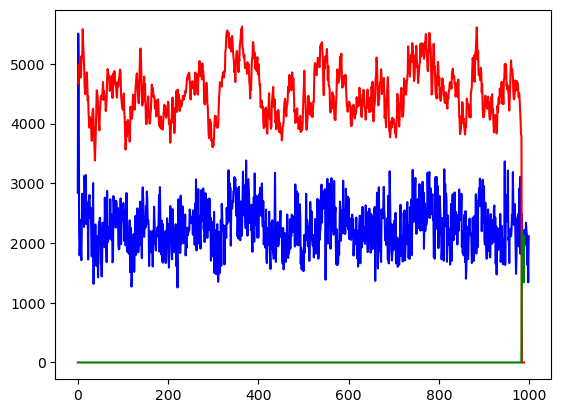

In [17]:
threshold, targets_only=cfar(rti_used,num_guard_cells=2, num_ref_cells=4, bias=2)

threshold=threshold[10:1010]
targets_only=targets_only[10:1010]

plt.plot(rti_for_det[:,150],c='b')
plt.plot(threshold,label="Threshold",c='r')
plt.plot(targets_only,c='g')
plt.show

# Testing Plane Detection algorithm

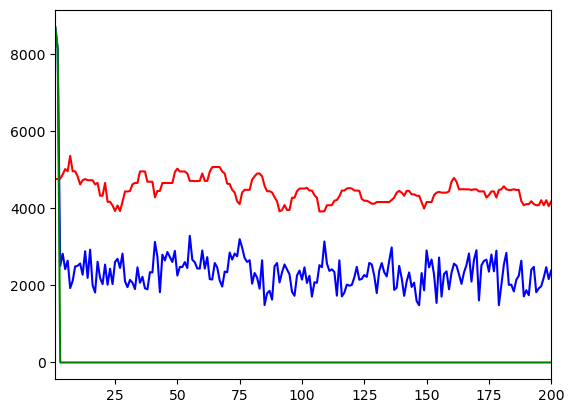

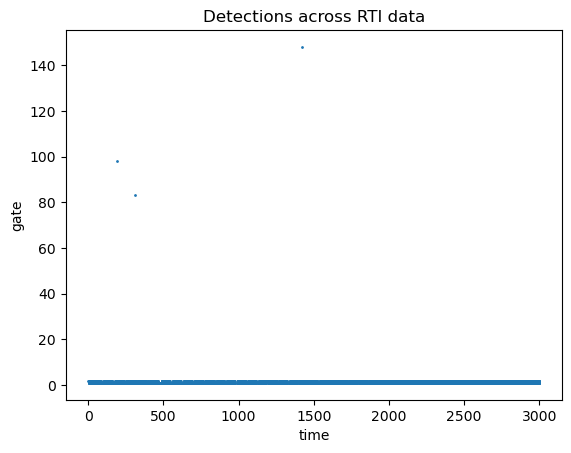

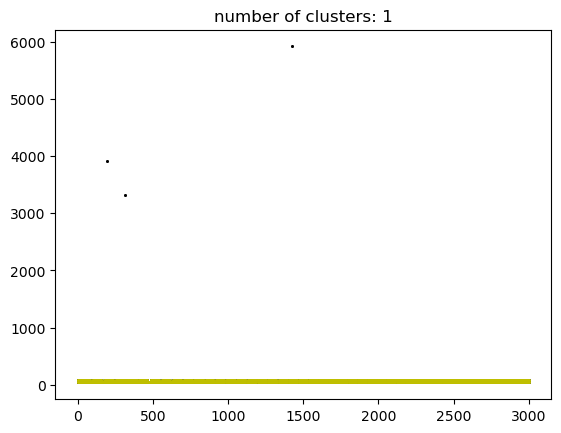

In [18]:
#Detection_options={"num_ref_cells":10,"num_guard_cells":3,"bias":1.9,"gate_range":(0,200),"edge_method":'symetric',"method":np.median,"eps":55,"min_samples":5,"y_scaling":40}

detections,other1,other2,peak_idx=detect_plane(rti=rti_for_det,start_samples=2000,detect_options={"gate_range":(1,200)},optional_plots=[2500,'CFAR_plot','plot_detections',"DBSCAN"]) #[1045,'plot_detections','CFAR_plot','DBSCAN'])

In [19]:
other2

[{'plane_number': 0,
  'max_time': 3000,
  'min_time': 1,
  'max_gate': 2.0,
  'min_gate': 1.0}]

# Clustering Algorithm

In [20]:
x_coords, y_coords ,idx_cooords,list_peaks_idx_1D= zip(*detections)

In [21]:
x_coords=np.multiply(x_coords,40)

In [22]:
x_coords

array([80, 40, 80, ..., 80, 40, 80])

In [23]:
new_arr=np.array(list(zip(y_coords,x_coords)))
new_arr

array([[   1,   80],
       [   2,   40],
       [   2,   80],
       ...,
       [2999,   80],
       [3000,   40],
       [3000,   80]])

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

In [25]:
# Load data in X
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.50, random_state=0)

In [26]:
X[1,1]

7.48059603271815

['y', 'b', 'g', 'r']


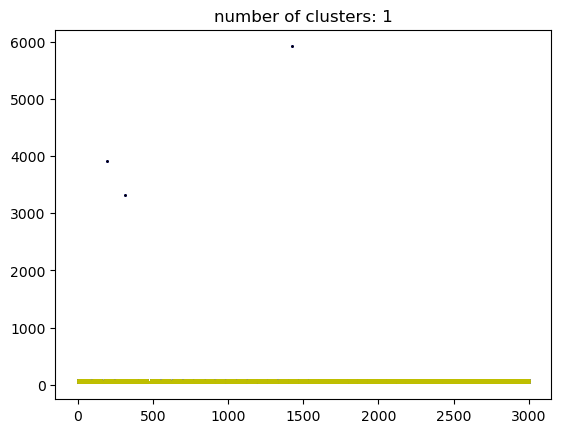

In [27]:
db = DBSCAN(eps=55, min_samples=5).fit(new_arr)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
print(colors)
plt.scatter(y_coords,x_coords,c='b',s=1)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = new_arr[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col,s=1)

    xy = new_arr[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=col,s=1)

plt.title('number of clusters: %d' % n_clusters_)
plt.show()

In [28]:
unique_labels = set(labels)
if -1 in unique_labels:
    unique_labels.remove(-1)
unique_labels = list(unique_labels)

# Create a dictionary to store points for each cluster
clustered_points = {}

# Iterate through unique labels and get points for each cluster
for label in unique_labels:
    clustered_points[label] = new_arr[labels == label]

In [29]:
cluster=0
proporties=[]
while cluster<= n_clusters_:
    print(clustered_points[cluster])
    cluster+=1

print(proporties)

[[   1   80]
 [   2   40]
 [   2   80]
 ...
 [2999   80]
 [3000   40]
 [3000   80]]


KeyError: 1

In [ ]:
plane=clustered_points[0]
plane[:,1]
maximim=np.max(plane[:,0])
maximim
minimum=np.min(plane[:,0])
minimum

1

# Tuning Plane Detection Algorithm
I will adjust each variable individually, and then see how they compare to each other in graphs here.

## Varying num_ref_cells

Detection_options={"num_ref_cells":1,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=1")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=3")

Detection_options={"num_ref_cells":5,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=5")

Detection_options={"num_ref_cells":10,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=10")

Detection_options={"num_ref_cells":50,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=50")

Detection_options={"num_ref_cells":200,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_ref_cells=200")

threshold_1 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=1, bias=2)
threshold_3 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2)
threshold_5 = cfar_fast(rti_for_det[:,150],num_guard_cells=1, num_ref_cells=5, bias=2)
threshold_10 = cfar_fast(rti_for_det[:,150],num_guard_cells=1, num_ref_cells=10, bias=2)
threshold_50 = cfar_fast(rti_for_det[:,150],num_guard_cells=1, num_ref_cells=50, bias=2)

plt.plot(rti_for_det[:,150],label="RTI Data",linewidth=3)
plt.plot(threshold_1, label="1 ref cell",c="pink")
plt.plot(threshold_3,label="3 ref cells")
plt.plot(threshold_5,label="5 ref cells")
plt.plot(threshold_10,label="10 ref cells")
plt.plot(threshold_50,label="50 ref cells",c="black")
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.title("CFAR with varying num_ref_cells")


## Varying num_guard_cells

Detection_options={"num_ref_cells":3,"num_guard_cells":1,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=1")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=3")

Detection_options={"num_ref_cells":3,"num_guard_cells":5,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=5")

Detection_options={"num_ref_cells":3,"num_guard_cells":10,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=10")

Detection_options={"num_ref_cells":3,"num_guard_cells":50,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=50")

Detection_options={"num_ref_cells":3,"num_guard_cells":200,"bias":2.27,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with num_guard_cells=200")

threshold_1 = cfar_fast(rti_for_det[:,150],num_guard_cells=1, num_ref_cells=3, bias=2)
threshold_3 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2)
threshold_5 = cfar_fast(rti_for_det[:,150],num_guard_cells=5, num_ref_cells=3, bias=2)
threshold_10 = cfar_fast(rti_for_det[:,150],num_guard_cells=10, num_ref_cells=3, bias=2)
threshold_50 = cfar_fast(rti_for_det[:,150],num_guard_cells=50, num_ref_cells=3, bias=2)


plt.plot(rti_for_det[:,150],label="RTI Data",linewidth=3)
plt.plot(threshold_1, label="1 guard cell",c="pink")
plt.plot(threshold_3,label="3 guard cells")
plt.plot(threshold_5,label="5 guard cells")
plt.plot(threshold_10,label="10 guard cells")
plt.plot(threshold_50,label="50 guard cells")
plt.legend(loc='upper right')
plt.xlim(0,200)
plt.title("CFAR with varying num_guard_cells")

## Bias

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":1.5,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=1.5")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":1.75,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=1.75")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=2")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2.25,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=2.25")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":3,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=3")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":4,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections with bias=4")

threshold_1 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=1.5)
threshold_2 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=1.75)
threshold_3 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2)
threshold_4 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2.25)
threshold_5 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=3)
threshold_6 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=4)

plt.plot(rti_for_det[:,150],label="RTI Data",linewidth=3)

plt.plot(threshold_1, label="bias=1.5")
plt.plot(threshold_2, label="bias=1.75")
plt.plot(threshold_3, label="bias=2")
plt.plot(threshold_4, label="bias=2.25")
plt.plot(threshold_5, label="bias=3")
plt.plot(threshold_6, label="bias=4")

plt.legend(loc='upper right')
plt.xlim(0,200)
plt.title("CFAR with varying bias")

## Method

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2,"gate_range":'Range gate #',"edge_method":'mean',"method":np.mean}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections using np.mean")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2,"gate_range":'Range gate #',"edge_method":'mean',"method":np.max}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections using np.max")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2,"gate_range":'Range gate #',"edge_method":'mean',"method":np.min}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections using np.min")

Detection_options={"num_ref_cells":3,"num_guard_cells":3,"bias":2,"gate_range":'Range gate #',"edge_method":'mean',"method":np.median}
detections,other1,other2,peak_idx=detect_plane(rti_for_det,2000,Detection_options,['plot_detections'])
plt.title("RTI Detections using np.median")

threshold_1 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2,method=np.mean)
threshold_2 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2,method=np.max)
threshold_3 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2,method=np.min)
threshold_4 = cfar_fast(rti_for_det[:,150],num_guard_cells=3, num_ref_cells=3, bias=2,method=np.median)
plt.plot(rti_for_det[:,150],label="RTI Data",linewidth=3)

plt.plot(threshold_1, label="method=np.mean")
plt.plot(threshold_2, label="method=np.max")
plt.plot(threshold_3, label="method=np.min")
plt.plot(threshold_4, label="method=np.median")


plt.legend(loc='upper right')
plt.xlim(0,200)
plt.title("CFAR with varying method")